# Class 7 - 29.4.19

# Advanced Pandas

Currently, pandas' `Series` and `DataFrame` might seem to us as no more than tables with too-complicated indexing methods. But this notion is far away from the truth, as we'll soon see.

## Missing Data

The last question in the previous class pointed us to working with missing data. But how and why does missing data occur?

One option is pandas' index alignment, the property that makes sure that each value will have the same index throughout the entire computation process.

In [1]:
import pandas as pd
import numpy as np


A = pd.Series([2, 4, 6], index=[0, 1, 2])
B = pd.Series([1, 3, 5], index=[1, 2, 3])
A + B

matplotlib data path C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\matplotlib\mpl-data
loaded rc file C:\Users\Hagai\.matplotlib\matplotlibrc
matplotlib version 2.1.2
verbose.level helpful
interactive is False
platform is win32


0    NaN
1    5.0
2    9.0
3    NaN
dtype: float64

The NaNs we have are what we call missing data - this is the way pandas represents it. We'll discuss about it in detail in a few moments.

The same thing occurs with DataFrames:

In [2]:
A = pd.DataFrame(np.random.randint(0, 20, (2, 2)),
                 columns=list('AB'))
A

,A,B
0,3,13
1,15,18


In [3]:
B = pd.DataFrame(np.random.randint(0, 10, (3, 3)),
                 columns=list('BAC'))
B

,B,A,C
0,3,8,4
1,1,8,7
2,4,0,3


In [4]:
A + B

,A,B,C
0,11.0,16.0,NaN
1,23.0,19.0,NaN
2,NaN,NaN,NaN


The DF's shape is the shape of the larger DF, and the "extra" row (index 2) was filled with NaNs. Since we have NaNs, the data type of the column is implicitly converted to a floating point type. Python doesn't have integer NaNs.

Another way to introduce missing data is through reindexing. If we "resample" our data we can achieve the following:

In [5]:
df = pd.DataFrame(np.random.randn(5, 3), index=['a', 'c', 'e', 'f', 'h'],
                  columns=['one', 'two', 'three'])
df

,one,two,three
a,1.084939,-1.130826,0.674753
c,-0.431731,1.953183,-1.052925
e,1.095927,0.470106,-0.077171
f,0.084044,2.057753,-0.045518
h,0.272893,0.193062,0.936804


In [6]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three
a,1.084939,-1.130826,0.674753
b,NaN,NaN,NaN
c,-0.431731,1.953183,-1.052925
d,NaN,NaN,NaN
e,1.095927,0.470106,-0.077171
f,0.084044,2.057753,-0.045518
g,NaN,NaN,NaN
h,0.272893,0.193062,0.936804


As we mentioned, pandas is oriented towards handling missing data. In general one finds two approaches that one can take - either create a masking array around the DF, in which `False` values represent invalid entries, or create a _sentinel_ value that represents missing data, like -99999 or NaN.

These two approaches have their downsides - a boolean masks requires more memory, and perhaps longer computation times. The sentinel value might lead to use of inefficient data types and slow down computation as well.

Due to its reliance on numpy, pandas chose the path of sentinel values, with either `None` or NaN as the value.

### The `None` object

`None` is standard Python's null value. It can be found in many places in the language. For example, functions that don't have a `return` statement, implicitly return `None`. While `None` can be used as a missing data type, it's probably not the best choice.

In [7]:
vals1 = np.array([1, None, 3, 4])
vals1

array([1, None, 3, 4], dtype=object)

The `dtype` is `object`, because the best common type of `int`s and a `None` is a Python `object`. This slows down computation time on these arrays:

In [8]:
for dtype in ['object', 'int']:
    print("dtype =", dtype)
    %timeit np.arange(1E6, dtype=dtype).sum()
    print()

dtype = object
158 ms ± 39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

dtype = int
6.15 ms ± 817 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



Another thing we can't do is aggregation:

In [9]:
vals1.sum()

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

### The `NaN` value

`NaN` is a special floating-point value recognized by all programming languages that conform to the IEEE standard (which means most of them). As we mentioned before, it forces the entire array to have a floating point type:

In [10]:
vals2 = np.array([1, np.nan, 3, 4])
vals2.dtype

dtype('float64')

Creating floating point arrays is very fast, so performance isn't hindered. NaN is sometimes described as a "data virus", since it infects objects it touches:

In [11]:
1 + np.nan

nan

In [12]:
0 * np.nan

nan

In [13]:
vals2.sum(), vals2.min(), vals2.max()  # runtime warnings, not exceptions

C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


(nan, nan, nan)

However, pandas objects account for NaNs in their calculations, as we'll soon see.

pandas can handle both `NaN` and `None` interchangeably:

In [14]:
ser = pd.Series([1, np.nan, 2, None])
ser

0    1.0
1    NaN
2    2.0
3    NaN
dtype: float64

### The `NaT` value

When dealing with datetime values or indices, the missing value is represented as `NaT`, or not-a-time:

In [15]:
df['timestamp'] = pd.Timestamp('20180101')
df

,one,two,three,timestamp
a,1.084939,-1.130826,0.674753,2018-01-01
c,-0.431731,1.953183,-1.052925,2018-01-01
e,1.095927,0.470106,-0.077171,2018-01-01
f,0.084044,2.057753,-0.045518,2018-01-01
h,0.272893,0.193062,0.936804,2018-01-01


In [16]:
df2 = df.reindex(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'])
df2

,one,two,three,timestamp
a,1.084939,-1.130826,0.674753,2018-01-01
b,NaN,NaN,NaN,NaT
c,-0.431731,1.953183,-1.052925,2018-01-01
d,NaN,NaN,NaN,NaT
e,1.095927,0.470106,-0.077171,2018-01-01
f,0.084044,2.057753,-0.045518,2018-01-01
g,NaN,NaN,NaN,NaT
h,0.272893,0.193062,0.936804,2018-01-01


### Operations and calculations with missing data

In [17]:
a = pd.DataFrame(np.random.random((5, 2)), columns=['one', 'two'])
a.iloc[1, 1] = np.nan
a

,one,two
0,0.201866,0.301795
1,0.995410,NaN
2,0.966848,0.122161
3,0.960021,0.419164
4,0.501532,0.737864


In [18]:
b = pd.DataFrame(np.random.random((6, 3)), columns=['one', 'two', 'three'])
b.iloc[2, 2] = np.nan
b

,one,two,three
0,0.383568,0.728219,0.155775
1,0.890214,0.804870,0.534928
2,0.810200,0.670660,NaN
3,0.377511,0.360014,0.873096
4,0.825984,0.987515,0.393951
5,0.875155,0.387428,0.346653


In [19]:
a + b

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,NaN
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.327516,NaN,1.725378
5,NaN,NaN,NaN


As we see, missing values propagate naturally through these arithmetic operations. Statistics also works:

In [20]:
(a + b).describe()
# Summation - NaNs are zero.
# If everything is NaN - the result is NaN as well.
# pandas' cumsum and cumprod ignore NaNs but preserve them in the resulting arrays.

,one,three,two
count,5.000000,0.0,4.000000
mean,1.382631,NaN,1.081847
std,0.512143,NaN,0.444209
min,0.585434,NaN,0.779177
25%,1.327516,NaN,0.789410
50%,1.337531,NaN,0.911417
75%,1.777048,NaN,1.203855
max,1.885624,NaN,1.725378


We can also receive a boolean mask of the NaNs in a dataframe:

In [21]:
mask = (a + b).isnull()
mask

,one,three,two
0,False,True,False
1,False,True,True
2,False,True,False
3,False,True,False
4,False,True,False
5,True,True,True


#### Filling missing values

The simplest option is to use the `fillna` method:

In [22]:
summed = a + b
summed.iloc[4, 0] = np.nan
summed

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,NaN
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,NaN,NaN,1.725378
5,NaN,NaN,NaN


In [23]:
summed.fillna(0)

,one,three,two
0,0.585434,0.0,1.030013
1,1.885624,0.0,0.000000
2,1.777048,0.0,0.792820
3,1.337531,0.0,0.779177
4,0.000000,0.0,1.725378
5,0.000000,0.0,0.000000


In [24]:
summed.fillna('missing')  # changed dtype to "object"

,one,three,two
0,0.585434,missing,1.03001
1,1.88562,missing,missing
2,1.77705,missing,0.79282
3,1.33753,missing,0.779177
4,missing,missing,1.72538
5,missing,missing,missing


In [25]:
summed.fillna(method='pad')  # The NaN column remained the same, but values were propagated forward
# We can also use the "backfill" method to fill in values to the back

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,1.030013
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.337531,NaN,1.725378
5,1.337531,NaN,1.725378


In [26]:
summed.fillna(method='pad', limit=1)  # No more than one padded NaN in a row

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,1.030013
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.337531,NaN,1.725378
5,NaN,NaN,1.725378


In [27]:
summed.fillna(summed.mean())  # each column received its respective mean. The NaN column is untouched.

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,1.081847
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.396409,NaN,1.725378
5,1.396409,NaN,1.081847


#### Dropping missing values

We've already seen in the short exercise the `dropna` method, that allows us to drop missing values:

In [28]:
summed

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,NaN
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,NaN,NaN,1.725378
5,NaN,NaN,NaN


In [29]:
filled = summed.fillna(summed.mean())
filled

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,1.081847
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.396409,NaN,1.725378
5,1.396409,NaN,1.081847


In [30]:
filled.dropna(axis=1)  # each column containing NaN is dropped

,one,two
0,0.585434,1.030013
1,1.885624,1.081847
2,1.777048,0.792820
3,1.337531,0.779177
4,1.396409,1.725378
5,1.396409,1.081847


In [31]:
filled.dropna(axis=0)  # each row containing a NaN is dropped

,one,three,two


#### Interpolation

The last way to to fill in missing values is through interpolation.

The default interpolation methods perform linear interpolation on the data, based on its ordinal index:

In [32]:
summed

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,NaN
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,NaN,NaN,1.725378
5,NaN,NaN,NaN


In [33]:
summed.interpolate()  # notice all the details in the interpolation of the three columns

,one,three,two
0,0.585434,NaN,1.030013
1,1.885624,NaN,0.911417
2,1.777048,NaN,0.792820
3,1.337531,NaN,0.779177
4,1.337531,NaN,1.725378
5,1.337531,NaN,1.725378


We can also interpolate with the actual index values in mind:

In [34]:
# Create "missing" index
timeindex = pd.Series(['1/1/2018', '1/4/2018', '1/5/2018', '1/7/2018', '1/8/2018'])
timeindex = pd.to_datetime(timeindex)
data_to_interp = [1, np.nan, 5, np.nan, 8]
df_to_interp = pd.DataFrame(data_to_interp, index=timeindex)
df_to_interp

,0
2018-01-01,1.0
2018-01-04,NaN
2018-01-05,5.0
2018-01-07,NaN
2018-01-08,8.0


In [35]:
df_to_interp.interpolate()  # the index values aren't taken into account

,0
2018-01-01,1.0
2018-01-04,3.0
2018-01-05,5.0
2018-01-07,6.5
2018-01-08,8.0


In [36]:
df_to_interp.interpolate(method='index')  # notice how the data obtains the "right" values

,0
2018-01-01,1.0
2018-01-04,4.0
2018-01-05,5.0
2018-01-07,7.0
2018-01-08,8.0


Pandas has many other interpolation methods, based on SciPy's. 

In [37]:
df_inter_2 = pd.DataFrame({'A': [1, 2.1, np.nan, 4.7, 5.6, 6.8],
                           'B': [.25, np.nan, np.nan, 4, 12.2, 14.4]})
df_inter_2

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [38]:
df_inter_2.interpolate(method='polynomial', order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-2.703846
2,3.451351,-1.453846
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


## Hierarchical Indexing

Last time we mentioned that while a DataFrame is inherently a 2D object, it can contain multi-dimensional data. The way a DataFrame (and a Series) does that is with Hierarchical Indexing, or sometimes Multi-Indexing.

After the deprecation of `pd.Panel`, this is the only remaining way to represent data of higher dimensions in pandas, making it a very useful tool for data science.

### Simple Example - Temperature in a Grid

Let's assume I wish to represent points on a 2D grid, perhaps inside a square, that represent the temperature in different locations around this grid. The obvious way to do this is to define a set of two coordinates, $(x, y)$, which point to a specific location inside my square. These two coordinates should also have a value attached to them - the temperature. A list of such coordinates can be a simple Series:

In [39]:
values = np.array([1.2, 0.8, 3.1, 0.1, 0.05, 1, 1.4, 2.1, 2.9])
coords = [('r0', 'c0'), ('r0', 'c1'), ('r0', 'c2'), 
          ('r1', 'c0'), ('r1', 'c1'), ('r1', 'c2'), 
          ('r2', 'c0'), ('r2', 'c1'), ('r2', 'c2')]  # r is row, c is column
points = pd.Series(values, index=coords, name='temperature')
points

(r0, c0)    1.20
(r0, c1)    0.80
(r0, c2)    3.10
(r1, c0)    0.10
(r1, c1)    0.05
(r1, c2)    1.00
(r2, c0)    1.40
(r2, c1)    2.10
(r2, c2)    2.90
Name: temperature, dtype: float64

It is important we understand that this is a series because _the data is one-dimensional_. The actual data is contained in `values`, a one-dimensional array. We do have two coordinates for each point, but the data itself - the temperature - is one-dimensional.

Currently the index is a simple tuple of coordinates. It's a single column, containing tuples. Pandas can help us to index this data in a more intuitive manner, using a MultiIndex object.

In [40]:
mindex = pd.MultiIndex.from_tuples(coords)
mindex

MultiIndex(levels=[['r0', 'r1', 'r2'], ['c0', 'c1', 'c2']],
           labels=[[0, 0, 0, 1, 1, 1, 2, 2, 2], [0, 1, 2, 0, 1, 2, 0, 1, 2]])

Let's examine this object carefully. 

`levels` is a nested list containing the different options for the index. Each level of the index is a single list, and the fact that we have two lists means that our index has a level of 2. A regular index has a level of 1.

`labels` is the specific ordering of the data with respect to the `levels`. It's how our data is organized. Each list in `labels` has the length of the entire index, and its values represent the labels of that index, as written in `levels`. If you recall `np.where`, then you'll notice that the output of that function is identical to the `labels`.

It's easier to understand if we just examine the data. Let's `reindex` our data:

In [41]:
points = points.reindex(mindex)
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

This looks good. Each index level is represented by a column, with the data being the last one. The "missing" values indicate that the value in that cell is the same as the value above it.

You might have assumed that accessing the data now is much more intuitive. Let's look at the values of all the points in the first row, `r0`:

In [42]:
points.loc['r0', :]  # .loc() is label-based indexing

r0  c0    1.2
    c1    0.8
    c2    3.1
Name: temperature, dtype: float64

Or the values of points in the second column:

In [43]:
points.loc[:, 'c1']

r0    0.80
r1    0.05
r2    2.10
Name: temperature, dtype: float64

Notice that `.iloc` disregards the MultiIndex, treating our data as a simple one-dimensional vector (as it actually is):

In [44]:
points.iloc[6]
# points.iloc[0, 1]  # ERRORS

1.4

Besides making the syntax cleaner, these slicing operations are as efficient as their single-dimension counterparts.

It should be clear that a MultiIndex can have more than two levels. Modelling a 3D cube (with the temperatures inside it) is as easy as:

In [45]:
values3d = np.array([1.2, 0.8, 
                     3.1, 0.1, 
                     0.05, 1, 
                     1.4, 2.1, 
                     2.9, 0.3,
                     2.4, 1.9])
# 3D coordinates with a shape of (r, c, z) = (3, 2, 2)
coords3d = [('r0', 'c0', 'z0'), ('r0', 'c0', 'z1'), 
            ('r0', 'c1', 'z0'), ('r0', 'c1', 'z1'),
            ('r1', 'c0', 'z0'), ('r1', 'c0', 'z1'),
            ('r1', 'c1', 'z0'), ('r1', 'c1', 'z1'), 
            ('r2', 'c0', 'z0'), ('r2', 'c0', 'z1'),
            ('r2', 'c1', 'z0'), ('r2', 'c1', 'z1')]  # we'll soon see an easier way to create this index
cube = pd.Series(values3d, index=pd.MultiIndex.from_tuples(coords3d), name='cube')
cube

r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: cube, dtype: float64

We can even name the individual levels, which helps with some slicing operations we'll see below:

In [46]:
cube.index.names = ['x', 'y', 'z']
cube

x   y   z 
r0  c0  z0    1.20
        z1    0.80
    c1  z0    3.10
        z1    0.10
r1  c0  z0    0.05
        z1    1.00
    c1  z0    1.40
        z1    2.10
r2  c0  z0    2.90
        z1    0.30
    c1  z0    2.40
        z1    1.90
Name: cube, dtype: float64

Again, you have to remember that this is one-dimensional data, with a three-dimensional index. In statistical term, we might term the indices a fixed, independent categorical variable, while the values are the dependent variable. Pandas actually has a `CategoricalIndex` object which you'll meet in your next HW.

### More on extra dimensions

In the previous square example, it's very appealing to ditch the MultiIndex altogether and just work with a DataFrame, or even a simple numpy array. This is because the two indices represented rows and columns. A quick way to turn one representation into the other is the `stack()`\\`unstack()` method:

In [47]:
points

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
Name: temperature, dtype: float64

In [48]:
pts_df = points.unstack()
pts_df

,c0,c1,c2
r0,1.2,0.80,3.1
r1,0.1,0.05,1.0
r2,1.4,2.10,2.9


In [49]:
pts_df.stack()  # back to a series

r0  c0    1.20
    c1    0.80
    c2    3.10
r1  c0    0.10
    c1    0.05
    c2    1.00
r2  c0    1.40
    c1    2.10
    c2    2.90
dtype: float64

So why bother with these (you haven't seen nothing yet) complicated multi-indices?

As you might have guessed, adding data points, i.e. increasing the dimensionality of the data, is very easy and intuitive. Data remains aligned through addition and deletion of data. Moreover, treating these categorical variables as an index can help the mental modeling of the problem, especially when you wish to perform statistical modeling with your analysis.

If you're not convinced yet, I'm sure that in a couple of examples you'll see their true power unfold.

### Constructing a MultiIndex

Creating a hierarchical index can be done in several ways:

In [50]:
pd.MultiIndex.from_arrays([['a', 'a', 'b', 'b'], [1, 2, 1, 2]])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [51]:
pd.MultiIndex.from_tuples([('a', 1), ('a', 2), ('b', 1), ('b', 2)])

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

In [52]:
pd.MultiIndex.from_product([['a', 'b'], [1, 2]])  # Cartesian product

MultiIndex(levels=[['a', 'b'], [1, 2]],
           labels=[[0, 0, 1, 1], [0, 1, 0, 1]])

The most common way to construct a MultiIndex, though, is to add to the existing index one of the columns of the DataFrame. We'll see how it's done below.

Another important note is that with DataFrames, the column and row index is symmetric. In effect this means that  the columns could also contain a MultiIndex:

In [53]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2]],
                                   names=['year', 'visit'])
columns = pd.MultiIndex.from_product([['Bob', 'Guido', 'Sue'], ['HR', 'Temp']],
                                     names=['subject', 'type'])

# mock some data
data = np.round(np.random.randn(4, 6), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data = pd.DataFrame(data, index=index, columns=columns)
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      12.0  38.2  39.0  38.1  29.0  36.5
     2      45.0  37.3  35.0  37.8  27.0  35.4
2014 1      48.0  40.0  42.0  36.4  39.0  38.0
     2      38.0  37.0  34.0  37.9  23.0  37.7

This sometimes might seem too much, and so usually people prefer to keep the column index as a simple list of names, moving any nestedness to the row index. This is due to the fact that usually columns represent the measured dependent variable.

In [54]:
index = pd.MultiIndex.from_product([[2013, 2014], [1, 2], ['Bob', 'Guido', 'Sue']],
                                   names=['year', 'visit', 'subject'])
columns = ['HR', 'Temp']

# mock some data
data = np.round(np.random.randn(12, 2), 1)
data[:, ::2] *= 10
data += 37

# create the DataFrame
health_data_row = pd.DataFrame(data, index=index, columns=columns)
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      37.0  39.1
           Guido    52.0  37.5
           Sue      30.0  38.3
     2     Bob      32.0  37.4
           Guido    21.0  37.5
           Sue      32.0  37.3
2014 1     Bob      44.0  37.3
           Guido    49.0  38.0
           Sue      42.0  37.3
     2     Bob      44.0  37.1
           Guido    47.0  38.8
           Sue      34.0  36.0

#### Creating a MultiIndex from a data column

While all of the above methods work, and could be useful sometimes, the most common method of creating an index is from an existing data column. 

In [55]:
location = ['AL', 'AL', 'NY', 'NY', 'NY', 'VA']
day = ['SUN', 'SUN', 'TUE', 'WED', 'SAT', 'SAT']
temp = [12.3, 14.1, 21.3, 20.9, 18.8, 16.5]
humidity = [31, 45, 41, 41, 49, 52]
states = pd.DataFrame(dict(location=location, day=day, 
                           temp=temp, humidity=humidity))
states

,day,humidity,location,temp
0,SUN,31,AL,12.3
1,SUN,45,AL,14.1
2,TUE,41,NY,21.3
3,WED,41,NY,20.9
4,SAT,49,NY,18.8
5,SAT,52,VA,16.5


In [56]:
states.set_index(['day'])

,humidity,location,temp
day,,,
SUN,31,AL,12.3
SUN,45,AL,14.1
TUE,41,NY,21.3
WED,41,NY,20.9
SAT,49,NY,18.8
SAT,52,VA,16.5


In [57]:
states.set_index(['day', 'location'])

humidity  temp
day location                
SUN AL              31  12.3
    AL              45  14.1
TUE NY              41  21.3
WED NY              41  20.9
SAT NY              49  18.8
    VA              52  16.5

In [58]:
states.set_index(['day', 'location'], append=True)

,,,humidity,temp
,day,location,,
0,SUN,AL,31,12.3
1,SUN,AL,45,14.1
2,TUE,NY,41,21.3
3,WED,NY,41,20.9
4,SAT,NY,49,18.8
5,SAT,VA,52,16.5


In [59]:
states.set_index([['i', 'ii', 'iii', 'iv', 'v', 'vi'], 'day'])

,,humidity,location,temp
,day,,,
i,SUN,31,AL,12.3
ii,SUN,45,AL,14.1
iii,TUE,41,NY,21.3
iv,WED,41,NY,20.9
v,SAT,49,NY,18.8
vi,SAT,52,VA,16.5


### Indexing and Slicing a MultiIndex

We'll use these DFs as an example:

In [60]:
health_data

subject      Bob       Guido         Sue      
type          HR  Temp    HR  Temp    HR  Temp
year visit                                    
2013 1      12.0  38.2  39.0  38.1  29.0  36.5
     2      45.0  37.3  35.0  37.8  27.0  35.4
2014 1      48.0  40.0  42.0  36.4  39.0  38.0
     2      38.0  37.0  34.0  37.9  23.0  37.7

In [61]:
health_data_row

HR  Temp
year visit subject            
2013 1     Bob      37.0  39.1
           Guido    52.0  37.5
           Sue      30.0  38.3
     2     Bob      32.0  37.4
           Guido    21.0  37.5
           Sue      32.0  37.3
2014 1     Bob      44.0  37.3
           Guido    49.0  38.0
           Sue      42.0  37.3
     2     Bob      44.0  37.1
           Guido    47.0  38.8
           Sue      34.0  36.0

If all we wish to do is to examine a column, indexing is very easy. Don't forget the DataFrame as dictionary analogy:

In [62]:
health_data['Guido']  # works for the column MultiIndex as expected

type          HR  Temp
year visit            
2013 1      39.0  38.1
     2      35.0  37.8
2014 1      42.0  36.4
     2      34.0  37.9

In [63]:
health_data_row['HR']  # that's a Series!

year  visit  subject
2013  1      Bob        37.0
             Guido      52.0
             Sue        30.0
      2      Bob        32.0
             Guido      21.0
             Sue        32.0
2014  1      Bob        44.0
             Guido      49.0
             Sue        42.0
      2      Bob        44.0
             Guido      47.0
             Sue        34.0
Name: HR, dtype: float64

In [64]:
# Accessing single elements is also pretty straight-forward
health_data_row.loc[2013, 1, 'Guido']  # index triplet

HR      52.0
Temp    37.5
Name: (2013, 1, Guido), dtype: float64

In [65]:
# We can even slice easily using the first MultiIndex (year in our case)
health_data_row.loc[2013:2017]  # 2017 doesn't exist, but Python's slicing rules prevent an exception here
# health_data_row.loc[1]  # doesn't work

HR  Temp
year visit subject            
2013 1     Bob      37.0  39.1
           Guido    52.0  37.5
           Sue      30.0  38.3
     2     Bob      32.0  37.4
           Guido    21.0  37.5
           Sue      32.0  37.3
2014 1     Bob      44.0  37.3
           Guido    49.0  38.0
           Sue      42.0  37.3
     2     Bob      44.0  37.1
           Guido    47.0  38.8
           Sue      34.0  36.0

Slicing is a bit more difficult when we want to take into account all available indices. This is due to the possible conflicts between the different indices and the columns.

Assuming we want to look at all the years, with all the visits, only by Bob - we would want to write something like this:

In [66]:
# health_data_row.loc[(:, :, 'Bob'), :]  # doesn't work

This pickle is solved in two possible ways:

In [67]:
# First option - the slice object
row_slice = (slice(None), slice(None), 'Bob')  # all years, all visits, of Bob
health_data_row.loc[row_slice, 'HR']
# arr[slice(None), 1] is the same as arr[:, 1]

year  visit  subject
2013  1      Bob        37.0
      2      Bob        32.0
2014  1      Bob        44.0
      2      Bob        44.0
Name: HR, dtype: float64

In [68]:
# First option - the slice object
row_idx = (slice(None), slice(None), slice('Bob', 'Guido'))  # all years, all visits, Bob + Guido
health_data_row.loc[row_idx, 'HR']

year  visit  subject
2013  1      Bob        37.0
             Guido      52.0
      2      Bob        32.0
             Guido      21.0
2014  1      Bob        44.0
             Guido      49.0
      2      Bob        44.0
             Guido      47.0
Name: HR, dtype: float64

In [69]:
# Second option - the IndexSlice object
idx = pd.IndexSlice
health_data_row.loc[idx[:, :, 'Bob'], :]  # very close to the naive implementation

HR  Temp
year visit subject            
2013 1     Bob      37.0  39.1
     2     Bob      32.0  37.4
2014 1     Bob      44.0  37.3
     2     Bob      44.0  37.1

In [70]:
idx2 = pd.IndexSlice
health_data_row.loc[idx2[2013:2015, 1, 'Bob':'Guido'], 'Temp']

year  visit  subject
2013  1      Bob        39.1
             Guido      37.5
2014  1      Bob        37.3
             Guido      38.0
Name: Temp, dtype: float64

There's one more way to index into a MultiIndex, which is very straight-forward and explicit when you're looking for specific values: The cross-section - 

In [71]:
# Third option - the cross-section - returns specific values
health_data_row.xs(key=(2013 , 1), level=('year', 'visit'))

,HR,Temp
subject,,
Bob,37.0,39.1
Guido,52.0,37.5
Sue,30.0,38.3


#### Small caveat - unsorted indices

Having an unsorted index in your MultiIndex might make the interpreter pop a few exceptions at you:

In [72]:
# char index in unsorted
index = pd.MultiIndex.from_product([['a', 'c', 'b'], [1, 2]])
data = pd.Series(np.random.rand(6), index=index)
data.index.names = ['char', 'int']
data

char  int
a     1      0.074366
      2      0.713691
c     1      0.699350
      2      0.857434
b     1      0.090384
      2      0.768888
dtype: float64

In [73]:
data['a':'b']

UnsortedIndexError: 'Key length (1) was greater than MultiIndex lexsort depth (0)'

`lexsort` means "lexicography-sorted", or sorted by either number or letter. Sorting an index is done with the `sort_index()` method:

In [74]:
data.sort_index(inplace=True)
print(data)
print(data['a':'b'])  # now it works

char  int
a     1      0.074366
      2      0.713691
b     1      0.090384
      2      0.768888
c     1      0.699350
      2      0.857434
dtype: float64
char  int
a     1      0.074366
      2      0.713691
b     1      0.090384
      2      0.768888
dtype: float64


### Data Aggregation

Data aggregation using a MultiIndex is amazingly simple:

In [75]:
states

,day,humidity,location,temp
0,SUN,31,AL,12.3
1,SUN,45,AL,14.1
2,TUE,41,NY,21.3
3,WED,41,NY,20.9
4,SAT,49,NY,18.8
5,SAT,52,VA,16.5


In [76]:
states.set_index(['location', 'day'], inplace=True)
states

humidity  temp
location day                
AL       SUN        31  12.3
         SUN        45  14.1
NY       TUE        41  21.3
         WED        41  20.9
         SAT        49  18.8
VA       SAT        52  16.5

In [77]:
states.mean(level='location')

,humidity,temp
location,,
AL,38.000000,13.200000
NY,43.666667,20.333333
VA,52.000000,16.500000


In [78]:
states.median(level='day')

,humidity,temp
day,,
SUN,38.0,13.20
TUE,41.0,21.30
WED,41.0,20.90
SAT,50.5,17.65


## Exercise

1. _Missing Data:_ Sample data sparsely from a sine wave. To do so:
    1. Create a `shape = (10000,)` 10-period sine wave with a predetermined phase and amplitude. Remember that a single period of sine starts at 0 and ends at 2$\pi$.
    2. Using `np.random.choice(replace=False)` sample 1000 points from the wave and place them in a Series.
    3. Plot the chosen points.
    4. Interpolate the points using linear interpolation and plot them on a different graph.
    5. Interpolate the points using quadratic interpolation and plot them on a different graph. 
    
1. _Replace Values:_ When we wish to replace values in a Series or DataFrame, we can do so in two main ways. The first, and most common, is a simple boolean masked, which we've already covered. The second method is the `.replace()` method of a Series\DataFrame.
    - Create a (10, 2) dataframe with increasing integer values 0-9 in both columns.
    - Use the `.replace()` method to replace the value 3 in the first column with 99.
    - Use it to replace 3 in column 0, and 1 in column 2, with 99.
    - Use its `method` keyword to replace values in the range [3, 6) of the first column with 6.

2. _MultiIndex #1:_ Construct a MultiIndex with 3 levels as the product of the following values: `(['a', b', 'c', 'd'], ['i', 'ii', 'iii'], ['x', 'y', 'z'])`. Populate the DataFrame with random values in two columns.
    - Extract in two different methods only the values with an index of `('a', 'ii', 'z')`.
    - Slice in two ways the values with an index of `'x'`.
    
3. _MultiIndex #2:_ Read the CSV from the previous class and parse at least two of its columns as indices. If you identify more columns that fit the role of an index - please make them such.
    - How many entries do you have for each index?
    - Aggregate the data based on its mean for each index level.

### Exercise solutions below...

#### 1

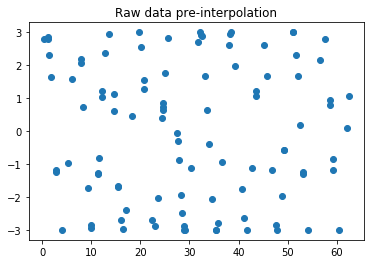

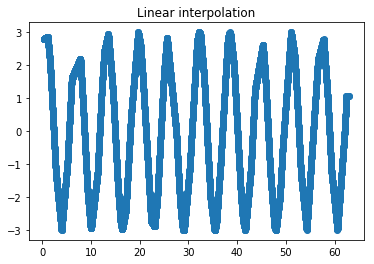

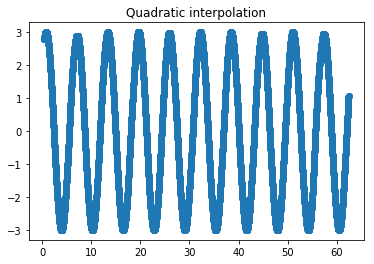

In [124]:
import matplotlib.pyplot as plt

num_periods = 10
num_reps = 10000
amp = 3
phase = np.pi / 4
x = np.linspace(0, 2*np.pi*num_periods, num=num_reps)
y = amp * np.sin(x + phase)

chosen_idx = np.random.choice(num_reps, size=100, replace=False)
data = pd.DataFrame(np.nan, index=x, columns=['raw'])
data.iloc[chosen_idx, 0] = y[chosen_idx]
fig1, ax1 = plt.subplots()
ax1.set_title('Raw data pre-interpolation')
data.raw.plot(marker='o')
data['lin_inter'] = data.raw.interpolate(method='index')
fig2, ax2 = plt.subplots()
ax2.set_title('Linear interpolation')
data.lin_inter.plot(marker='o')
data['quad_inter'] = data.raw.interpolate(method='quadratic')
fig3, ax3 = plt.subplots()
ax3.set_title('Quadratic interpolation')
data.quad_inter.plot(marker='o')

### 2

In [125]:
data = np.tile(np.arange(10)[:, np.newaxis], (1, 2))
df = pd.DataFrame(data)
df

,0,1
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [126]:
df.replace({0: 3}, {0: 99})

,0,1
0,0,0
1,1,1
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [127]:
df.replace({0: 3, 1: 1}, 99)

,0,1
0,0,0
1,1,99
2,2,2
3,99,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8
9,9,9


In [128]:
df[0].replace(np.arange(3, 6), method='bfill')

0    0
1    1
2    2
3    6
4    6
5    6
6    6
7    7
8    8
9    9
Name: 0, dtype: int32

### 3

In [129]:
letters = ['a', 'b', 'c', 'd']
roman = ['i', 'ii', 'iii']
coor = ['x', 'y', 'z']
index = pd.MultiIndex.from_product((letters, roman, coor))
data = np.random.randint(20, size=(len(letters) * len(roman) * len(coor), 2))
df = pd.DataFrame(data, columns=['today', 'tomorrow'], index=index)
df

today  tomorrow
a i   x      1        15
      y     10        18
      z     16        12
  ii  x     19         9
      y     15         7
      z     10         1
  iii x      9         9
      y      6         1
      z     17         7
b i   x      7         3
      y      9        13
      z      1         3
  ii  x     13        16
      y      7         9
      z      6         9
  iii x      0        19
      y      2        10
      z     19         6
c i   x     17        13
      y      3        10
      z     10        18
  ii  x     18         7
      y     14         3
      z      4        12
  iii x      4         6
      y     11        16
      z     13        18
d i   x      0        16
      y     14        17
      z     10        17
  ii  x      0        10
      y      1         8
      z      8         2
  iii x     17         1
      y      9        14
      z      4        10

In [130]:
# Extract specific values - 1
df.loc['a', 'ii', 'z']

today       10
tomorrow     1
Name: (a, ii, z), dtype: int32

In [131]:
# Extract specific values - 2
df.xs(key=('a', 'ii', 'z'))

today       10
tomorrow     1
Name: (a, ii, z), dtype: int32

In [132]:
# Extract specific values - 2
idx = pd.IndexSlice
df.loc[idx['a', 'ii', 'z'], :]

today       10
tomorrow     1
Name: (a, ii, z), dtype: int32

In [133]:
# Extract slice - 1
idx = pd.IndexSlice
df.loc[idx[:, :, 'x'], :]

today  tomorrow
a i   x      1        15
  ii  x     19         9
  iii x      9         9
b i   x      7         3
  ii  x     13        16
  iii x      0        19
c i   x     17        13
  ii  x     18         7
  iii x      4         6
d i   x      0        16
  ii  x      0        10
  iii x     17         1

In [134]:
# Extract slice - 2
df.xs(key='x', level=2)

today  tomorrow
a i        1        15
  ii      19         9
  iii      9         9
b i        7         3
  ii      13        16
  iii      0        19
c i       17        13
  ii      18         7
  iii      4         6
d i        0        16
  ii       0        10
  iii     17         1

### 4

In [135]:
reqs = pd.read_csv(r'311_service_requests.zip')
reqs.head()

C:\Users\Hagai\Miniconda3\envs\general\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (9,40,41,42,43,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,0,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,TLC,Correspondence - Taxi and Limousine Commission,Taxi Compliment,Driver Compliment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,19579718,01/11/2011 03:00:00 AM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Residential) (L10),NaN,10011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,2,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,TLC,Correspondence - Taxi and Limousine Commission,Taxi Compliment,Driver Compliment,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,19579917,01/11/2011 12:46:00 PM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Non-Residential) (L11),NaN,10128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,4,19580080,01/11/2011 05:03:00 PM,NaN,DEP,Department of Environmental Protection,Lead,Lead Kit Request (Residential) (L10),NaN,11208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [136]:
reqs.set_index(['Unnamed: 0', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', 'Bridge Highway Direction'], inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
Unnamed: 0,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [137]:
reqs.index.set_names('num', level=0, inplace=True)
reqs.head()

,,,,,,Unique Key,Created Date,Closed Date,Agency Name,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,...,Taxi Pick Up Location,Bridge Highway Name,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
num,Agency,Complaint Type,Descriptor,Location Type,Bridge Highway Direction,,,,,,,,,,,,,,,,,,,,,
0,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19574549,01/11/2011 03:47:18 PM,07/05/2011 04:08:01 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19579718,01/11/2011 03:00:00 AM,NaN,Department of Environmental Protection,10011,226 WEST 20 STREET,WEST 20 STREET,7 AVENUE,8 AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.742622,-73.997968,"(40.74262244714865, -73.99796826857371)"
2,TLC,Taxi Compliment,Driver Compliment,NaN,NaN,19573881,01/11/2011 11:31:02 AM,07/05/2011 04:07:58 PM,Correspondence - Taxi and Limousine Commission,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DEP,Lead,Lead Kit Request (Non-Residential) (L11),NaN,NaN,19579917,01/11/2011 12:46:00 PM,NaN,Department of Environmental Protection,10128,7 EAST 95 STREET,EAST 95 STREET,5 AVENUE,MADISON AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.787046,-73.955817,"(40.78704587425496, -73.95581736959971)"
4,DEP,Lead,Lead Kit Request (Residential) (L10),NaN,NaN,19580080,01/11/2011 05:03:00 PM,NaN,Department of Environmental Protection,11208,721 FOUNTAIN AVENUE,FOUNTAIN AVENUE,WORTMAN AVENUE,COZINE AVENUE,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.662730,-73.868878,"(40.66272996328775, -73.8688777423775)"


In [138]:
# Different entries for each index
reqs.count()

Unique Key                        300000
Created Date                      300000
Closed Date                       258815
Agency Name                       300000
Incident Zip                      292510
Incident Address                  247648
Street Name                       247620
Cross Street 1                    247870
Cross Street 2                    247755
Intersection Street 1              27723
Intersection Street 2              27725
Address Type                      289396
City                              292703
Landmark                             287
Facility Type                      40574
Status                            299999
Due Date                          107631
Resolution Description            270293
Resolution Action Updated Date    286853
Community Board                   300000
Borough                           300000
X Coordinate (State Plane)        275201
Y Coordinate (State Plane)        275201
Park Facility Name                300000
Park Borough    

## _n_-Dimensional Containers

While technically a DataFrame is a two-dimensional container, in the next lesson we'll see why it can perform quite efficienty as a pseudo n-dimensional container. 

If you wish to have _true_ n-dimensional DataFrame-like data structures, you should use the `xarray` package and its `xr.DataArray` and `xr.Dataset` objects, which we'll discuss in the next lessons.